In [1]:
import numpy as np
import os, sys, subprocess
import pandas as pd
import matplotlib.pyplot as plt


# We introduce functions in-line here, but they can be saved and imported as follows
# sys.path.insert(0, '../')  # Adds the project root to the PYTHONPATH
# from rsfc_tools import helpers

# Load in data

In [2]:
# First subject
sub_XC = np.genfromtxt('../data/rsfMRI_timeseries/sub-XC_parcellated_timeseries.txt')

# Second subject
sub_XA = np.genfromtxt('../data/rsfMRI_timeseries/sub-XA_parcellated_timeseries.txt')

In [3]:
# Looking at the shape of the data we just loaded in, we see it's 333 rows and 6000 columns

# The 333 rows represent 333 functionally homogonous regions of cortex known as "parcels"
# The 6000 columns represent 6000 frames of BOLD activity at each parcel

print(sub_XC.shape)
print(sub_XA.shape)

(333, 6000)
(333, 6000)


In [4]:
# OK that works for two subjects, what if you wanted to load in many?

# You'll want a list of all subjects in the analysis. This could be saved in a text file.
sub_list = np.genfromtxt('../data/sub_list.txt', str)
print(sub_list)

#Then you'll loop through the list and read in each subjects data.
data_dir = '../data/rsfMRI_timeseries'
rsfmri_data = np.zeros((len(sub_list),333,6000))

for i,sub in enumerate(sub_list):
    path_to_read = os.path.join(data_dir, f'sub-{sub}_parcellated_timeseries.txt')
    subject_data = np.genfromtxt(path_to_read)
    rsfmri_data[i] = subject_data

['XC' 'XA']


In [5]:
# Data structure holding all participants data in the order presented in sub_list
print(rsfmri_data.shape)

(2, 333, 6000)


# Data wrangling and exploration

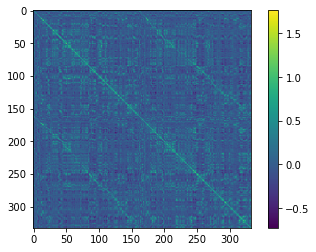

In [6]:
# Functional connectivity is the correlation structure between the timeseries at different brain regions

# np.corrcoef returns a correlation matrix that gives the correlation between all pairs of parcels (rows)
sub_XC_rsFC = np.corrcoef(sub_XC)

# We apply a Fisher Z-Transformation
np.fill_diagonal(sub_XC_rsFC, 0)
sub_XC_rsFC = np.arctanh(sub_XC_rsFC)
np.fill_diagonal(sub_XC_rsFC, 1)

# plt.imshow can be used to quickly view the correlation matrix we just created
plt.imshow(sub_XC_rsFC)
plt.colorbar()
plt.show()

In [7]:
# OK that works for one subject. What if we wanted to do create the correlation matrix for everyone?

# First, create a function that takes in a the rsFMRI timeseries data, and outputs the z-transformed connectivty
def create_corrmat(arr):
    """
    Generate a Fisher-transformed correlation matrix from a time series array.
    
    Parameters
    ----------
    arr : array_like
        2D array with shape (n_parcels, m_frames) where n_parcels is the number of parcels
        (variables) and m_frames is the number of frames (time points).
    Returns
    -------
    corrmat : ndarray
        The Fisher-transformed correlation matrix with the shape as `n x n`, where each
        element corrmat [i, j] represents the Fisher-transformed correlation coefficient
        between parcel i and parcel j. 
    """
    corrmat = np.corrcoef(arr)
    np.fill_diagonal(corrmat, 0)
    corrmat = np.arctanh(corrmat)
    np.fill_diagonal(corrmat, 1)
    return corrmat

# Then, apply that function to every participant. 
rsfc_data = np.zeros((len(sub_list),333,333))

# Loop though the participants in the rsFMRI data struture, create and store the correlation matricies
for i,sub in enumerate(rsfmri_data):
    rsfc_data[i] = create_corrmat(sub)

# Now we have connectivity data for each participant
print(rsfc_data.shape)

(2, 333, 333)


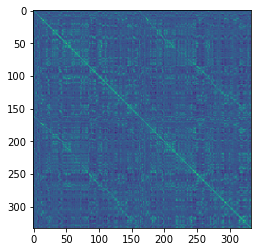

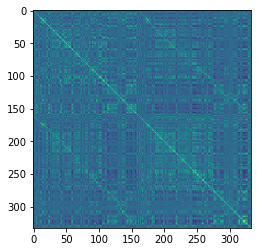

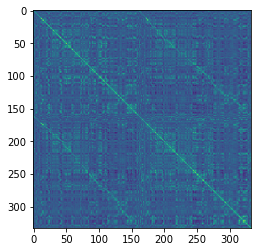

In [38]:
# Visualize the connectivity of each participant, then the group average.

plt.imshow(rsfc_data[0])
plt.show()
plt.imshow(rsfc_data[1])
plt.show()
plt.imshow(rsfc_data.mean(0))
plt.show()

In [39]:
# To see "functional networks", highly interconnected sets of nodes≤ appear in the correlation matrix
# We need to reorder the parcels based off network identify

# Load in the community structure from a group average data, created off this parcel set 
# Generation and Evaluation of a Cortical Area Parcellation from Resting-State Correlations (Gordon et al., 2016)


parcel_labels = pd.read_excel('../data/Parcels.xlsx')
parcel_labels

# This has the 333 labels, which the correlation matrix is currently ordered in, and the associated community

/Users/matt/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


ParcelID Hem  Surface area (mm2)    Centroid (MNI)    Community
0           1   L           1411.6436  -11.2 -52.4 36.5      Default
1           2   L            377.2543    -18.8 -48.7 65       SMhand
2           3   L            437.1466   -51.8 -7.8 38.5      SMmouth
3           4   L            368.6362     -11.7 26.7 57      Default
4           5   L            870.9255  -18.4 -85.5 21.6       Visual
..        ...  ..                 ...               ...          ...
328       329   R             15.9589    39.7 -22.5 2.6     Auditory
329       330   R            415.3981         55.8 2 -2     Auditory
330       331   R            101.3923    54.4 1.1 -12.9      Default
331       332   R            129.5680    57.1 -6.3 -7.7  VentralAttn
332       333   R             66.6635   46.6 -21.5 -8.5  VentralAttn

[333 rows x 5 columns]

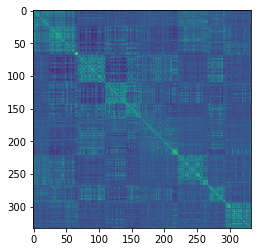

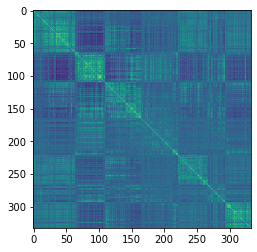

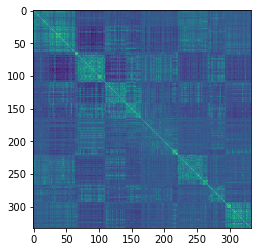

In [100]:
# Sort the parcels by community alphabetically
reorder_indicies = parcel_labels['Community'].argsort()
reordered_communities = parcel_labels['Community'].sort_values()

# Get the unique networks in the list, in the order they were sorted.
unique_networks, first_occurrences = np.unique(parcel_labels['Community'][reorder_indicies],return_index=True)

# We can reorganize our rsfc_data for each participant, based on this new ordering, which will be helpful later on.
rsfc_data_ordered = np.copy(rsfc_data[:,reorder_indicies,:][:,:,reorder_indicies])

# Now we can re-visalize our connectivity, with parcels sorted by canonical functional network
# We notice the block-diagonal structure appears, which compose the densely interconnected communities of parcels
# We visualize the connectivity of each participant, then the group average.

plt.imshow(rsfc_data_ordered[0])
plt.show()
plt.imshow(rsfc_data_ordered[1])
plt.show()
plt.imshow(rsfc_data_ordered.mean(0))
plt.show()

# Parcel similarity analysis

In [101]:
# One thing we may want to do, is look at how simlar is the conenctivity at a parcel between participants
# take 

parcel_similarity = np.zeros(333)
for i in range(333):
    parcel_similarity[i]=(np.corrcoef(rsfc_data[0,i,:],rsfc_data[1,i,:])[0,1])

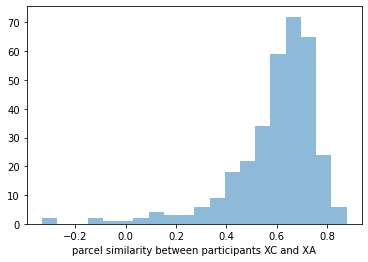

In [102]:
# Visualize parcel similarity as a histrogram
plt.hist(parcel_similarity, 20, alpha = .5)
plt.xlabel('parcel similarity between participants XC and XA')
plt.show()

In [103]:
network_similarity_list = [] 
# To see parcel similarity, organized by functional network we need to group the parcels accordingly
for i, net in enumerate(np.unique(parcel_labels['Community'])):
    net_inds= np.where(parcel_labels['Community']==net)[0]
    network_similarity_list.append(parcel_similarity[net_inds])

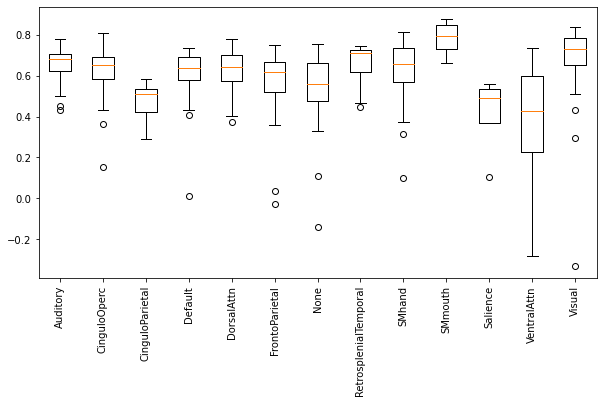

In [104]:
plt.figure(figsize=(10,5))
plt.boxplot(network_similarity_list)
plt.xticks(range(1,14), np.unique(parcel_labels['Community']), rotation = 90)
plt.show()

In [106]:
# We may want to view parcel_similarity between the participants on the cortex. To do this, we need to save the 333
# parcel similarity values, in the original parcel ordering, onto a CIFTI surface


# Here is a function I created to make this process easier

# This step requires having connectome workbench installed
# You may need to edit the path_to_wb variable with your own local path to the workbench installation


def save_nii(array, output_name, output_dir_path, wb_required_template_path, purge = True):
    
    path_to_wb = '/Applications/workbench/bin_macosx64/wb_command'

    
    '''
    Save a numpy array as a .nii file, utilizing workbench as an intermediary.
    Arguments:
        array: the numpy array to save
        output_name: the name to use for the output file
        output_dir_path: the directory path to save the output file in
        wb_required_template_path: a dtseries of the same dimension used as a template to write over
        purge: if True, delete the intermediate text file after creating the .nii file
    '''
    if not os.path.isdir(output_dir_path):
        raise Exception(f"The output folder {output_dir_path} does not exist")
    template_base = os.path.basename(wb_required_template_path)
    end = template_base.find('.')
    file_end = template_base[end:]
    out_path = os.path.join(output_dir_path, output_name)
    outnamecifti = out_path+file_end
    if os.path.isfile(outnamecifti):
        print('-WARNING: Overwriting')
    np.savetxt(out_path, array)
    wb_comm = ' '.join([path_to_wb, '-cifti-convert -from-text', out_path, wb_required_template_path, outnamecifti])
    subprocess.call(wb_comm, shell=True)
    if purge:
        os.remove(out_path)        


In [107]:
# Note the arguments in this function call. 
# First you provide the 333 values, ordered by gordon parcel #    
# Then you provide the desired output name, and output location
# Then provide a .nii template, which workbench requires inorder to write new values ontop of

# A copy of this template, Gordon333_TEMPLATE.pscalar.nii, is provided for your convenience in /data/misc

save_nii(parcel_similarity, 'parcel_similarity', '../results/', '../data/misc/Gordon333_TEMPLATE.pscalar.nii')

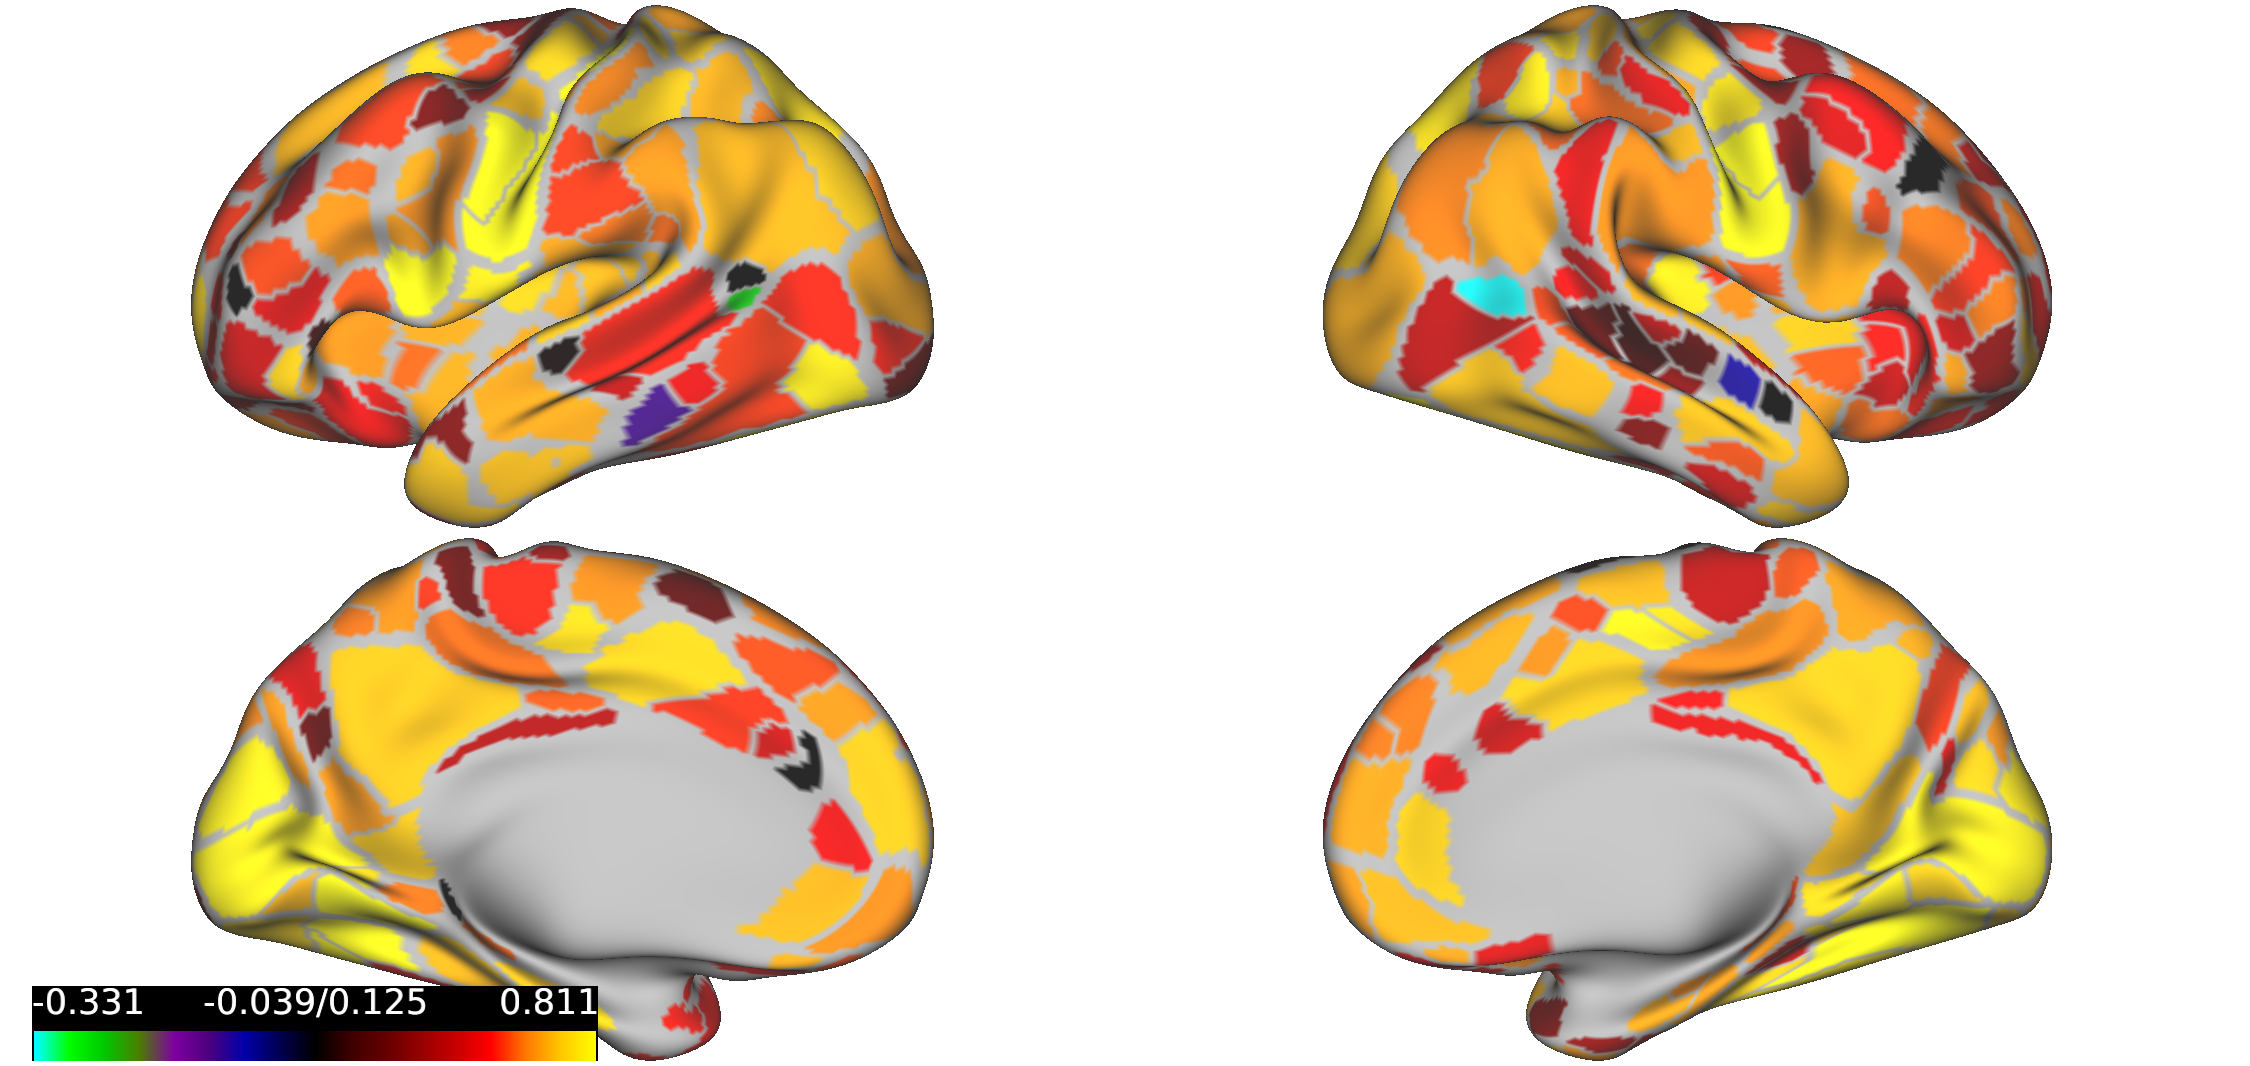

So far
* we loaded in parcellated timeseries data for two participants
* created the z-transformed connectivity for each participant
* calcuate the similarity of each parcels connectivty between the participants
* These values were then grouped by canonical network label
* And finally, we view the values directly ontop of the associated parcels


Note: To view these images by yourself, you would need to install connectome workbench https://www.humanconnectome.org/software/connectome-workbench, open up a cortical surface (e.g.; Conte69.R.inflated.32k_fs_LR.surf.gii), and then open up the parcel similarity file (e.g.; parcel_similarity.pscalar.nii). For your convenience, I include copies of these files inside ./data/misc and ./data/results respectively

# Block similarity analysis 

Full connectivity


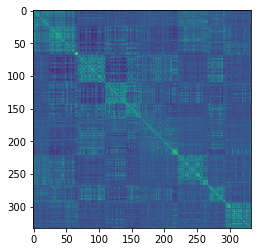

Just DMN-DMN block for both participants


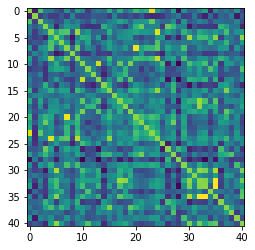

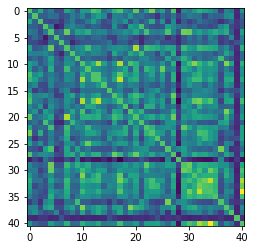

In [155]:
# What if we want to look at differences in connectivity within and between different specific networks?
# We need a way to query blocks in each participants connectivity matrix  

print('Full connectivity')
plt.imshow(rsfc_data_ordered[0])
plt.show()

# To query regions of the correlation matrix, we need to get the rows/columns belonging to the blocks of interest
# For example if, we want to see differences between the participants within the default mode network


# Get default indices
default_inds = np.where(reordered_communities=='Default')[0]

# Visualize just the DMN-DMN block for both participants 
print('Just DMN-DMN block for both participants')
plt.imshow(rsfc_data_ordered[0][default_inds,:][:,default_inds])
plt.show()
plt.imshow(rsfc_data_ordered[1][default_inds,:][:,default_inds])
plt.show()

In [162]:
# Similar to the parcel similarity analysis above, we can look at the correlation between the connectivty
# in each participants DMN-DMN block

# As correlation matricies are symmetric, we often just want to only look at the the upper triangle of a matrix
# so we don't not have duplicate features. Here is a helpful function to flatten an array into its upper triangle
def flatten_upper_triangle(arr): return arr[np.triu_indices_from(arr,1)]

sub1_dmnblock = flatten_upper_triangle(rsfc_data_ordered[0][default_inds,:][:,default_inds])
sub2_dmnblock = flatten_upper_triangle(rsfc_data_ordered[1][default_inds,:][:,default_inds])

print(f'Similarity between within-default connectivity between participants: \n{np.corrcoef(sub1_dmnblock,sub2_dmnblock)[0,1]}')

Similarity between within-default connectivity between participants: 
0.47349379757448634


In [171]:
# What if we wanted to do this for all blocks, i.e.; all pairs of networks

from itertools import combinations_with_replacement

# Define the list of combinations to loop through. The first 5 in the list are printed out for example
combo_list = list(combinations_with_replacement(unique_networks,2))
print(f'example combinations / blocks: \n\n{combo_list[:5]}')


# Loop through the list of combinations of networks and keep track of the mean absolute differences for each block
block_similarity = []
for combo in combo_list:
    net1, net2 = combo
    net1_inds = np.where(reordered_communities==net1)[0]
    net2_inds = np.where(reordered_communities==net2)[0]
    if net1 == net2:
        sub1_block = flatten_upper_triangle(rsfc_data_ordered[0][net1_inds,:][:,net2_inds])
        sub2_block = flatten_upper_triangle(rsfc_data_ordered[1][net1_inds,:][:,net2_inds])
    else: # For off diagnol blocks, we just pick one of the two identical ones, which are not themselves symettric, so we just flatten normally. 
        sub1_block = rsfc_data_ordered[0][net1_inds,:][:,net2_inds].flatten()
        sub2_block = rsfc_data_ordered[1][net1_inds,:][:,net2_inds].flatten()
    block_similarity.append(np.corrcoef(sub1_block,sub2_block)[0,1])
    

example combinations / blocks: 

[('Auditory', 'Auditory'), ('Auditory', 'CinguloOperc'), ('Auditory', 'CinguloParietal'), ('Auditory', 'Default'), ('Auditory', 'DorsalAttn')]


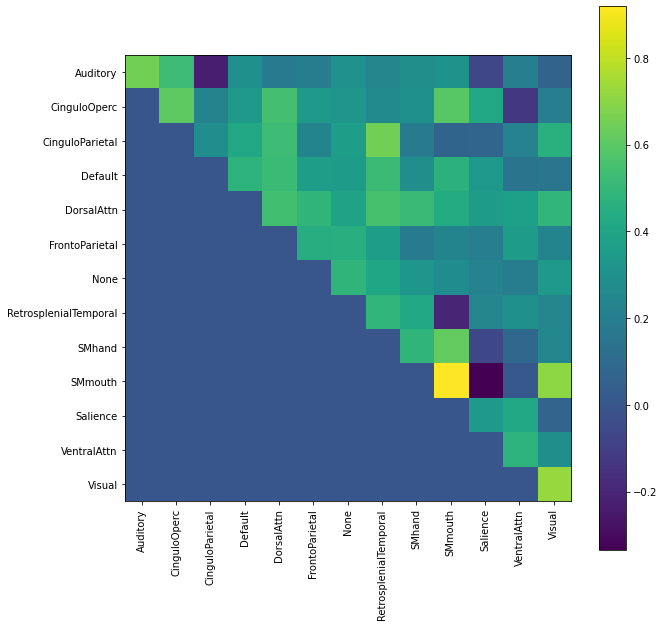

['SMmouth' 'SMmouth']
0.918316423513723
['Visual' 'Visual']
0.7261242269006384
['SMmouth' 'Visual']
0.7052687070734198
['CinguloParietal' 'RetrosplenialTemporal']
0.6533992266779444
['Auditory' 'Auditory']
0.6502762417066461


In [176]:
# Visualize the mean absolute differences between the participants, for each block
array = np.zeros((13, 13))
tri_upper_indices = np.triu_indices_from(array)

array[tri_upper_indices] = block_similarity
plt.figure(figsize=(10,10))
plt.imshow((array))
plt.xticks(ticks = range(13), labels=unique_networks, rotation = 90)
plt.yticks(ticks = range(13), labels=unique_networks)
plt.colorbar()
plt.show()


# Print out the top 5 similarity

sorted_block_sim_inds = np.argsort(np.abs(block_similarity))[::-1]
for i in range(5):
    print(np.array(combo_list)[sorted_block_sim_inds[i]])
    print(np.array(block_similarity)[sorted_block_sim_inds][i])
